In [1]:
import numpy as np
import warnings
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from skimage.color import rgb2gray
from glob import glob
seed = 100
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

In [2]:
#settings
plt.rc('font', size=16)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

np.random.seed(seed)

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.16.1


In [3]:

# creating dataset
genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}
path_image_files = "/kaggle/input/mel-spectrogram-images/mel_spectrogram_imgs"
genres = list(genre_dict.keys())

inputs = []
labels = []

for genre in genres:
    print("\t",path_image_files + "/" + genre + "/*")
    for name in glob(path_image_files + "/" + genre + "/*"):
        inputs.append(rgb2gray(mpimg.imread(name)[:,:,0:3]))
        labels.append(genre)
    print(len(inputs))
    print(len(labels))

	 /kaggle/input/mel-spectrogram-images/mel_spectrogram_imgs/blues/*
1100
1100
	 /kaggle/input/mel-spectrogram-images/mel_spectrogram_imgs/classical/*
2200
2200
	 /kaggle/input/mel-spectrogram-images/mel_spectrogram_imgs/country/*
3300
3300
	 /kaggle/input/mel-spectrogram-images/mel_spectrogram_imgs/disco/*
4400
4400
	 /kaggle/input/mel-spectrogram-images/mel_spectrogram_imgs/hiphop/*
5500
5500
	 /kaggle/input/mel-spectrogram-images/mel_spectrogram_imgs/jazz/*
6589
6589
	 /kaggle/input/mel-spectrogram-images/mel_spectrogram_imgs/metal/*
7689
7689
	 /kaggle/input/mel-spectrogram-images/mel_spectrogram_imgs/pop/*
8789
8789
	 /kaggle/input/mel-spectrogram-images/mel_spectrogram_imgs/reggae/*
9889
9889
	 /kaggle/input/mel-spectrogram-images/mel_spectrogram_imgs/rock/*
10989
10989


In [4]:
train_data = inputs
label_data = labels


In [5]:
inputs = np.asarray(inputs)
labels = np.asarray(labels)

enc = OneHotEncoder(sparse_output = False)
labels = labels.reshape(-1, 1)
labels = enc.fit_transform(labels)


In [6]:
print(labels.shape)
print(inputs.shape)
input_shape = inputs.shape[1:]
output_shape = labels.shape[1:]


(10989, 10)
(10989, 217, 334)


# Network

In [7]:
def RGLU(x, filters, name):
    x1 = tfkl.Conv1D(filters=filters, kernel_size=3, strides=1, padding="same", data_format="channels_first", name=name)(x)
    x2 = tfkl.Conv1D(filters=filters, kernel_size=3, strides=1, padding="same", data_format="channels_first", name=name + 'B')(x)
    x1 = tfkl.BatchNormalization()(x1)
    x2 = tfkl.BatchNormalization()(x2)
    x1 = tfk.activations.sigmoid(x1)
    y = tfkl.Multiply()([x1,x2])
    if x.shape == y.shape:
        y = tfkl.Add()([x, y])
    return y

In [10]:
def stratified_multilabel_kfold(X, y, n_splits=10, shuffle_data=True, random_state=None):
    """
    Stratified K-Fold cross-validation for multilabel data with 80/10/10 train/validation/test split.
    
    Parameters:
    - X: Feature matrix.
    - y: Multilabel binary matrix (samples x labels).
    - n_splits: Number of folds (default is 10).
    - shuffle_data: Whether to shuffle the data before splitting.
    - random_state: Seed for shuffling (if applicable).

    Returns:
    - folds: List of (train_index, val_index, test_index) tuples for each fold.
    """
    if shuffle_data:
        X, y = shuffle(X, y, random_state=random_state)
    
    n_samples, n_labels = y.shape
    
    # Desired sizes for train, validation, and test sets
    n_test = n_val = n_samples // n_splits
    n_train = n_samples - n_test - n_val

    fold_indices = [[] for _ in range(n_splits)]
    label_counts_per_fold = [np.zeros(n_labels) for _ in range(n_splits)]
    
    # Get the number of labels per sample
    samples_with_counts = [(i, y[i].sum()) for i in range(n_samples)]
    samples_with_counts = sorted(samples_with_counts, key=lambda x: x[1], reverse=True)

    # Assign each sample to the fold with the least corresponding labels
    for sample_index, _ in samples_with_counts:
        min_fold = np.argmin([label_counts_per_fold[i].sum() for i in range(n_splits)])
        fold_indices[min_fold].append(sample_index)
        label_counts_per_fold[min_fold] += y[sample_index]

    # Create the train/validation/test splits
    folds = []
    for i in range(n_splits):
        test_indices = fold_indices[i]
        remaining_indices = [idx for j in range(n_splits) if j != i for idx in fold_indices[j]]
        
        # Shuffle remaining indices to randomize the split
        if shuffle_data:
            np.random.seed(random_state)
            np.random.shuffle(remaining_indices)
        
        val_indices = remaining_indices[:n_val]
        train_indices = remaining_indices[n_val:n_val + n_train]
        
        folds.append((train_indices, val_indices, test_indices))

    return folds


In [12]:
def build_model_rglu_lstm(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    filters = 64
    
    x = tfkl.Conv1D(filters=filters, kernel_size=3, strides=1, padding="same", data_format="channels_first", name='conv')(input_layer)
    for i in range(5):
        x = RGLU(x, filters, 'conv_' + str(i))
        if (i == 1 or i == 3):
            filters += 64
        if (i == 3):
            filters += 64
        x = RGLU(x, filters, 'conv2_' + str(i))
        x = tfkl.MaxPooling1D(pool_size=2, strides=2, padding="valid", data_format="channels_first", name='mp' + str(i))(x)

    # LSTM layer
    x = tfkl.LSTM(units=256, return_sequences=True)(x)
    
    x1 = tfkl.GlobalAveragePooling1D(data_format='channels_first')(x)
    x2 = tfkl.GlobalMaxPooling1D(data_format='channels_first')(x)
    x = tfkl.Concatenate()([x1, x2])
    
    x = tfkl.Dense(units=200, activation='relu', name='dense1')(x)
    x = tfkl.Dense(units=100, activation='relu', name='dense2')(x)
    x = tfkl.Dropout(0.2)(x)
    output_layer = tfkl.Dense(units=10, activation='softmax', name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='RGLU_LSTM')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model


In [13]:
custom_folds = stratified_multilabel_kfold(inputs, labels, random_state=42)
accuracies = []
precisions = []
recalls = []
f1_scores = []

for fold, (train_indices, val_indices, test_indices) in enumerate(custom_folds):
    
    X_train, X_val, X_test = inputs[train_indices], inputs[val_indices], inputs[test_indices]
    y_train, y_val, y_test = labels[train_indices], labels[val_indices], labels[test_indices]
    
    print(f"Fold {fold + 1}")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    print()

    model = build_model_rglu_lstm()
    early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=50, mode='auto', restore_best_weights=True)
    
    # Train the model and save its history
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=32,
        epochs=500,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    ).history
    
    # Predict the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Calculate metrics for this fold
    accuracies.append(accuracy_score(y_true, y_pred_classes))
    precisions.append(precision_score(y_true, y_pred_classes, average='weighted'))
    recalls.append(recall_score(y_true, y_pred_classes, average='weighted'))
    f1_scores.append(f1_score(y_true, y_pred_classes, average='weighted'))


Fold 1
X_train shape: (8792, 217, 334), y_train shape: (8792, 10)
X_val shape: (1098, 217, 334), y_val shape: (1098, 10)
X_test shape: (1099, 217, 334), y_test shape: (1099, 10)

Epoch 1/500
275/275 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.2366 - loss: 2.0307 - val_accuracy: 0.4035 - val_loss: 1.5878
Epoch 2/500
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4235 - loss: 1.5173 - val_accuracy: 0.5191 - val_loss: 1.3038
Epoch 3/500
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5192 - loss: 1.3076 - val_accuracy: 0.5574 - val_loss: 1.2182
Epoch 4/500
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6089 - loss: 1.1007 - val_accuracy: 0.6375 - val_loss: 1.0444
Epoch 5/500
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.6593 - loss: 0.9608 - val_accuracy: 0.6785 - val_loss: 0.9438
Epoch 6/500
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.7318 - loss: 0.7872 - val_accuracy: 0.7313 - val_loss: 0.8019
Epoch 7/500
275/275 ━━━━━━━━━━━━━━━

In [14]:
#RGLU-LSTM
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)

print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean F1-Score: {mean_f1_score:.4f}')

Mean Accuracy: 0.9037
Mean Precision: 0.9048
Mean Recall: 0.9037
Mean F1-Score: 0.9035


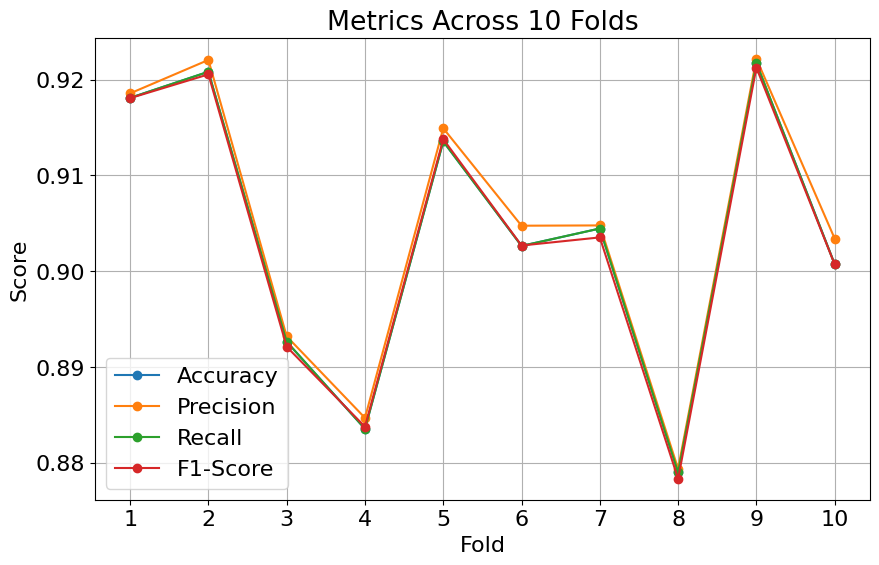

In [15]:
folds = range(1, 11)

plt.figure(figsize=(10, 6))

plt.plot(folds, accuracies, marker='o', label='Accuracy')
plt.plot(folds, precisions, marker='o', label='Precision')
plt.plot(folds, recalls, marker='o', label='Recall')
plt.plot(folds, f1_scores, marker='o', label='F1-Score')
plt.title('Metrics Across 10 Folds')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.show()